In [1]:
from biocre import diopy_read 
from biocre import scanpy_read_mtx 
from biocre import scanpy_read_h5 
from biocre import linkage
from biocre import calculate_pvalue
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# BioCRE support three types of input data.
# 1. read processed h5 by diopy

rna_adata = diopy_read('pbmc_unsorted_3k_rna.h5', assay_name = 'RNA')
atac_adata = diopy_read('pbmc_unsorted_3k_atac.h5', assay_name = 'peak')
print(rna_adata)
print(atac_adata)

AnnData object with n_obs × n_vars = 3009 × 25880
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    layers: 'counts'
AnnData object with n_obs × n_vars = 3009 × 115978
    obs: 'orig.ident', 'nCount_peak', 'nFeature_peak'
    layers: 'counts'


In [3]:
# 2. read h5 from cellranger output
# https://www.10xgenomics.com/datasets/pbmc-from-a-healthy-donor-no-cell-sorting-3-k-1-standard-1-0-0
# rna_adata and atac_adata read from cellranger output is suggested to filter low quality cells.
# i.e. Scanpy(https://scanpy.readthedocs.io/en/stable/) or Seurat(https://satijalab.org/seurat/) 

rna_adata, atac_adata = scanpy_read_h5('pbmc_unsorted_3k_filtered_feature_bc_matrix.h5')
print(rna_adata)
print(atac_adata)

View of AnnData object with n_obs × n_vars = 3009 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
View of AnnData object with n_obs × n_vars = 3009 × 81156
    var: 'gene_ids', 'feature_types', 'genome'


In [4]:
# 3. read mtx from cellranger output
# https://www.10xgenomics.com/datasets/pbmc-from-a-healthy-donor-no-cell-sorting-3-k-1-standard-1-0-0

rna_adata, atac_adata = scanpy_read_mtx('filtered_feature_bc_matrix')
print(rna_adata)
print(atac_adata)

View of AnnData object with n_obs × n_vars = 3012 × 36601
    var: 'gene_ids', 'feature_types'
View of AnnData object with n_obs × n_vars = 3012 × 77242
    var: 'gene_ids', 'feature_types'


In [5]:
# Read meta data from cellranger output

meta_data = pd.read_csv('filtered_feature_bc_matrix/features.tsv.gz', header = None, sep = '\t')

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [05:05<00:00, 12.72s/it]


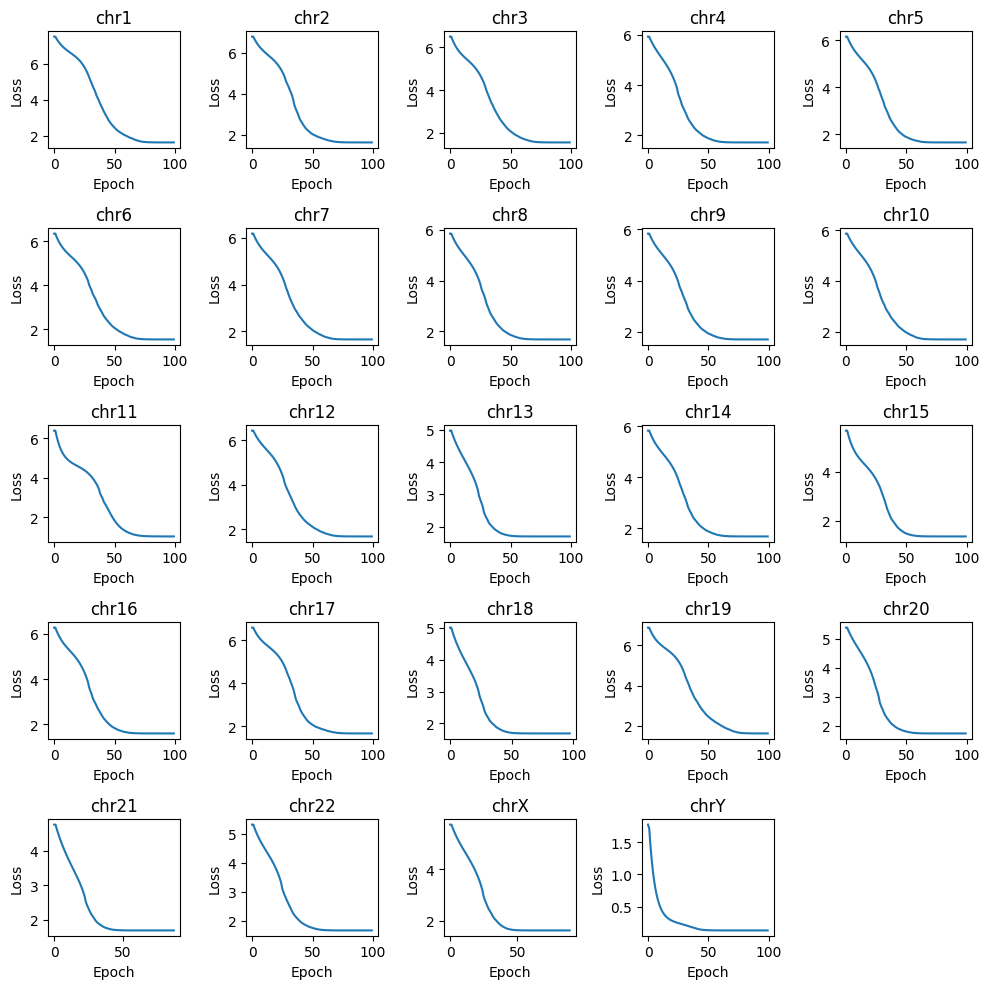

In [6]:
# Running BioCRE
# Normalization of RNA and ATAC is suggested which makes converge more fast.

result = linkage(rna_adata, 
                 atac_adata, 
                 meta_data, 
                 lr=0.1, 
                 max_iter=100, 
                 plot=True)

In [7]:
# Calculate p value of gene-peak in 1MB region.

result_pvalue = calculate_pvalue(result, 
                                 meta_data,
                                 upstearm = 500000,
                                 downstream = 500000
                                )

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [07:23<00:00, 18.46s/it]


In [8]:
# Select significant CREs

result_pvalue_sig = result_pvalue[result_pvalue['Combine_p_value'] < 1e-7].sort_values(by='Combine_p_value', ascending=True)
result_pvalue_sig

,Gene,Peak,Value,P.adj_Gene,P.adj_Peak,Combine_p_value
278319,ZFAND3,chr6-37818315-37820781,0.016587,6.212793e-159,0.000000e+00,0.000000e+00
550530,RGCC,chr13-41455058-41467400,0.032407,0.000000e+00,0.000000e+00,0.000000e+00
459303,CCDC88B,chr11-64846676-64849269,0.000746,0.000000e+00,0.000000e+00,0.000000e+00
879277,NKG7,chr19-51371944-51373727,0.018956,2.232756e-291,0.000000e+00,0.000000e+00
459302,CCDC88B,chr11-64843207-64845631,0.000606,0.000000e+00,1.608329e-206,0.000000e+00
...,...,...,...,...,...,...
333015,GIMAP4,chr7-150448408-150452564,0.000942,4.306184e-04,1.560779e-05,9.957071e-08
518484,NCKAP1L,chr12-54195643-54196872,0.001037,4.463632e-04,3.474899e-32,9.963486e-08
237673,AC005740.5,chr5-141412976-141413133,0.000176,4.461545e-04,2.337731e-07,9.964603e-08
897155,DDRGK1,chr20-3121155-3121741,0.000810,4.439508e-04,2.488806e-06,9.966848e-08


In [9]:
# Consistent with other tools.  https://stuartlab.org/signac/articles/pbmc_multiomic

result_pvalue_sig.iloc[np.where(result_pvalue_sig['Gene'] == 'MS4A1')[0], :][0:10]

,Gene,Peak,Value,P.adj_Gene,P.adj_Peak,Combine_p_value
450524,MS4A1,chr11-60455335-60456056,0.002255,1.899881e-211,0.000000e+00,0.000000e+00
450525,MS4A1,chr11-60476922-60477552,0.001696,2.625212e-120,0.000000e+00,3.445868e-240
450528,MS4A1,chr11-60498433-60499373,0.001436,1.258450e-86,0.000000e+00,7.918488e-173
450548,MS4A1,chr11-60931826-60933709,0.001223,4.715586e-63,0.000000e+00,1.111838e-125
450544,MS4A1,chr11-60911969-60916194,0.000965,2.349589e-39,1.779802e-193,2.760285e-78
450520,MS4A1,chr11-60377567-60378968,0.000890,1.853015e-33,0.000000e+00,1.716832e-66
450521,MS4A1,chr11-60389106-60390023,0.000483,2.151314e-09,0.000000e+00,2.314075e-18
450513,MS4A1,chr11-60310611-60311044,0.000465,1.270956e-08,0.000000e+00,8.076649e-17
450529,MS4A1,chr11-60528920-60529384,0.000460,1.989151e-08,0.000000e+00,1.978362e-16
450532,MS4A1,chr11-60618639-60619110,0.000450,5.152414e-08,0.000000e+00,1.327368e-15
